<a href="https://colab.research.google.com/github/Berigny/AI-Entrainment-Protocol/blob/main/LENR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Energy Nuclear (LENR) Cycles Model
This notebook tests whether a minimal, topology-first model can simulate and falsify a low-energy nuclear reaction (LENR) cycle driven by breath-like EM coherence. Using Discrete Exterior Calculus (DEC) on a star-tetrahedral complex with a shared centroid, we evolve fields, enforce first-law energy accounting, monitor entropy production and phase relations, and—optionally—add an adelic (ℝ × ℚ_p) layer to represent hierarchical memory at the fusion node. If quantised heat bursts do not emerge with lawful topology, pre-burst EM signatures, rising EPR, and correct energy balance, the hypothesis is weakened. If they do, we proceed to richer modelling and lab validation. The prize is significant: a path to low-cost, high-yield, sustainable energy in an energy-hungry world.

## Falsification criteria

We consider the LENR cycle unsupported if any lawful configuration fails to produce:
(i) pre-burst EM coherence with ~90° E–M phase and centroid mediation,
(ii) quantised heat steps at the sink,
(iii) a non-negative EPR that rises prior to bursts, and
(iv) first-law integrity (residual ≈ 0).
Controls must behave as expected: illegal shortcuts reduce irreversibility or break energy accounting; removing C→3 or 1→2 kills bursts; random primes revert to baseline.

## Notebook Overview & Research Aim
### Goal
- Simulate and *attempt to falsify* LENR-like cycles on a tetrahedral (and star-tetrahedral) topology.
- If not falsified, motivate deeper modelling and lab tests for low-cost, high-yield, sustainable energy.
### Key Ideas
- DEC on simplicial complexes; mediation via centroid **C**; breath-driven, asymmetric flows; adelic (ℝ×ℚ_p) layer.

In [ ]:
# @title 1. **Imports & Global Config** { display-mode: "form" }
# @markdown **What this sets**
# @markdown - Imports, numeric precision/warnings, plotting defaults, reproducibility seeds.

import numpy as np
import networkx as nx
from mpmath import mpf, power
import matplotlib.pyplot as plt


# Geometry (simplices, orientations, dual volumes)

In [ ]:
# @title 2. **Geometry — S1 (Single Tetra) and Star (S1+S2) with Cubic Bridges** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds the base directed graph `G` for one tetrahedron (S1) or the full star (S1+S2) if `USE_STAR=True`.
# @markdown - Defines vertices `{0,1,2,3,C}` for S1 and adds `{4,5,6,7}` for S2 in star mode.
# @markdown - Encodes work-like edges, heat-dump edges, and mediation paths through centroid `C`.
# @markdown - Adds optional cross-tetra “cubic” bridges for coherent work transfer and heat redistribution.
# @markdown - Inserts self-loops for stability/linger dynamics.
# @markdown - Labels canonical edge sets (`work_edges`, `heat_edges`) inside `G.graph` for later diagnostics.

# === Geometry — S1 (tetra) and optional Star (S1+S2) with cubic bridges ===
# Inputs: USE_STAR (bool) defined in C01_config; default to False if missing
try:
    USE_STAR
except NameError:
    USE_STAR = False

import networkx as nx
from mpmath import mpf

# Nodes
S1 = ['0','1','2','3']      # sinks even / branches odd
S2 = ['4','5','6','7']
ALL = (S1 + ['C']) if not USE_STAR else (S1 + S2 + ['C'])

# Helper
r = lambda x: mpf(str(x))

# Core single-shell flows (work/heat + mediation) on S1
core_edges_S1 = [
    ('C','1', {'rate': r(0.5)}),     # pump
    ('1','2', {'rate': r(0.8)}),     # E→M (work)
    ('2','C', {'rate': r(0.9)}),     # return to mediator
    ('C','3', {'rate': r(0.7)}),     # squeeze/fusion path
    ('3','0', {'rate': r(1.0)}),     # heat dump
    ('0','C', {'rate': r(0.3)}),     # reset
]

# Optional second shell (S2)
core_edges_S2 = [
    ('C','5', {'rate': r(0.5)}),
    ('5','6', {'rate': r(0.8)}),
    ('6','C', {'rate': r(0.9)}),
    ('C','7', {'rate': r(0.7)}),
    ('7','4', {'rate': r(1.0)}),
    ('4','C', {'rate': r(0.3)}),
]

# Cross-shell bridges (only used if USE_STAR)
cross_edges = [
    ('3','6', {'rate': r(0.35)}),  # work bridge S1→S2
    ('7','2', {'rate': r(0.25)}),  # heat-biased return to S1 magnetic
    ('5','0', {'rate': r(0.20)}),  # heat assist into S1 sink
    ('1','6', {'rate': r(0.20)}),  # optional E→M assist across shells
]

# Build graph once
G = nx.DiGraph()
G.add_nodes_from(ALL)
G.add_edges_from(core_edges_S1)

if USE_STAR:
    G.add_edges_from(core_edges_S2 + cross_edges)
    self_loop_nodes = S1 + S2
else:
    self_loop_nodes = S1

# Self-loops (linger/stability)
G.add_edges_from([(n, n, {'rate': r(0.4)}) for n in self_loop_nodes])

# Label canonical edge sets (for later coupling/diagnostics)
work_edges = {('1','2'), ('3','6')} if USE_STAR else {('1','2')}
heat_edges = {('3','0')} | ({('7','2'), ('5','0')} if USE_STAR else set())

G.graph['work_edges'] = work_edges
G.graph['heat_edges'] = heat_edges

print(f"Graph ready. USE_STAR={USE_STAR} |V|={G.number_of_nodes()} |E|={G.number_of_edges()}")


Graph ready. USE_STAR=False |V|=5 |E|=10


In [ ]:
# @title 3. **Breath Operator — Inhale/Exhale Rhythm** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Defines a transformer `apply_breath(G_base, step)` that scales edge rates
# @markdown   according to the breath cycle.
# @markdown - Even steps = inhale: favour flows into sinks (`0,4`) and mediator `C`.
# @markdown - Odd steps = exhale: favour flows out of `C` toward pump branches (`1,3,5,7`).
# @markdown - Parameters `inhale_gain` and `exhale_gain` control modulation strength.
# @markdown - Returns a fresh graph copy and the current phase label (`"in"` / `"out"`).


def apply_breath(G_base, step, inhale_gain=1.15, exhale_gain=1.10,
                 sinks=('0','4'), sources=('C',), pumps=('1','3','5','7')):
    """Scale edge rates by breath phase. Even steps = inhale (toward sinks/C), odd = exhale (from C→pumps)."""
    phase = 'in' if (step % 2) == 0 else 'out'
    G = G_base.copy()
    for u, v, d in G.edges(data=True):
        r = float(d.get('rate', 0.0))
        if phase == 'in' and (v in sinks or v in sources):
            d['rate'] = r * inhale_gain
        elif phase == 'out' and (u in sources and v in pumps):
            d['rate'] = r * exhale_gain
    return G, phase


# DEC operators (∂, Hodge stars, audits)

In [ ]:
# @title 4. **DEC Backbone — ∂ Operators & Diagonal Hodge Stars (with Audits)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Builds the simplicial backbone (independent of the Markov graph): vertices, oriented edges, faces.
# @markdown - Constructs boundary maps: **B₁** (nodes→edges) and **B₂** (edges→faces).
# @markdown - Defines **diagonal SPD Hodge stars** `Star1` (edges×edges) and `Star2` (faces×faces).
# @markdown - Runs audits: `||B₁·B₂||∞ ≈ 0`, ranks of B₁/B₂, SPD minima; exposes `energy_field(E,B)`.
# @markdown **Notes**
# @markdown - No rectangular/“incidence-averaged” Hodge stand-ins here. Those are deprecated.

import numpy as np
from scipy.sparse import csr_matrix

# ---- 1) Vertex & face set (S1 always; S2 included if USE_STAR=True) ----
try:
    USE_STAR
except NameError:
    USE_STAR = False

# Vertices: S1 plus shared centroid C; extend with S2 in star mode
V = ['0','1','2','3','C'] + (['4','5','6','7'] if USE_STAR else [])

# Faces:
# - S1 outer + centroid faces
F_S1_outer = [('0','1','2'), ('0','1','3'), ('0','2','3'), ('1','2','3')]
F_S1_cent  = [('0','1','C'), ('0','2','C'), ('0','3','C'), ('1','2','C'), ('1','3','C'), ('2','3','C')]

# - Optional S2 outer + centroid faces (only if USE_STAR)
F_S2_outer = [('4','5','6'), ('4','5','7'), ('4','6','7'), ('5','6','7')]
F_S2_cent  = [('4','5','C'), ('4','6','C'), ('4','7','C'), ('5','6','C'), ('5','7','C'), ('6','7','C')]

F = F_S1_outer + F_S1_cent + (F_S2_outer + F_S2_cent if USE_STAR else [])

# ---- 2) Oriented edges derived from faces (backbone edges only) ----
edges_backbone = sorted({(a,b) for (a,b,c) in F for (a,b) in ((a,b),(b,c),(c,a))})

# Index maps
node_id = {v:i for i,v in enumerate(V)}
edge_id = {e:i for i,e in enumerate(edges_backbone)}
face_id = {f:i for i,f in enumerate(F)}

# ---- 3) Boundary maps ----
# B1: nodes×edges (∂1)
B1 = np.zeros((len(V), len(edges_backbone)), dtype=float)
for (u,v), ei in edge_id.items():
    B1[node_id[u], ei] = -1.0
    B1[node_id[v], ei] = +1.0
B1 = csr_matrix(B1)

# B2: edges×faces (∂2) with oriented incidence
B2 = np.zeros((len(edges_backbone), len(F)), dtype=float)
for fj,(v0,v1,v2) in enumerate(F):
    for (a,b) in ((v0,v1),(v1,v2),(v2,v0)):
        sign = +1.0
        e = (a,b)
        if e not in edge_id:
            e = (b,a); sign = -1.0
        B2[edge_id[e], fj] += sign
B2 = csr_matrix(B2)

# ---- 4) Diagonal Hodge stars (regularised circumcentric stand-ins) ----
# Use a unit geometric scale here; SI scaling lives in the optional calibration cell.
L = 1.0  # assumed primal edge length scale for now
nE, nF = len(edges_backbone), len(F)


# primal measures
len_e  = np.full(nE, L, dtype=float)                       # |e|
area_f = np.full(nF, (np.sqrt(3)/4.0)*L*L, dtype=float)    # |f| (equilateral)

# crude-but-coherent dual measures for a regular/star tetra
dual_e = np.full(nE, (L*L)/4.0, dtype=float)               # |*e|
dual_f = np.full(nF, (L/3.0), dtype=float)                 # |*f|

star1_diag = dual_e / len_e          # edges→edges
star2_diag = dual_f / area_f         # faces→faces

Star1 = np.diag(star1_diag)          # SPD
Star2 = np.diag(star2_diag)

def star1(x): return Star1 @ x
def star2(x): return Star2 @ x

# ---- 5) Audits ----
D1 = B1.toarray(); D2 = B2.toarray()
B1B2 = D1 @ D2
inf_norm = float(np.max(np.abs(B1B2))) if B1B2.size else 0.0
rank_D1 = int(np.linalg.matrix_rank(D1))
rank_D2 = int(np.linalg.matrix_rank(D2))
is_spd_star1 = bool(np.min(star1_diag) > 0)
is_spd_star2 = bool(np.min(star2_diag) > 0)

print(f"[dims] |V|={len(V)} |E|={nE} |F|={nF}")
print(f"||B1·B2||_∞ = {inf_norm:.3e} (expect 0)")
print(f"rank(B1)={rank_D1}, rank(B2)={rank_D2}")
print(f"Star1 SPD? {is_spd_star1}   Star2 SPD? {is_spd_star2}")
print(f"star1_diag min/max = {star1_diag.min():.3e} / {star1_diag.max():.3e}")
print(f"star2_diag min/max = {star2_diag.min():.3e} / {star2_diag.max():.3e}")

# ---- 6) Energy helper ----
def energy_field(E, B):
    """Discrete EM energy: 0.5*(E⋅(⋆1 E) + B⋅(⋆2 B))."""
    return 0.5*(E @ (Star1 @ E) + B @ (Star2 @ B))

# ---- 7) shape asserts ----

assert D1.shape == (len(V), len(edge_id))          # nodes × edges
assert D2.shape == (len(edge_id), len(F))          # edges × faces
assert (D2.T @ np.zeros(D1.shape[1])).shape[0] == len(F)
assert (D2 @ np.zeros(len(F))).shape[0] == len(edge_id)


[dims] |V|=5 |E|=15 |F|=10
||B1·B2||_∞ = 0.000e+00 (expect 0)
rank(B1)=4, rank(B2)=10
Star1 SPD? True   Star2 SPD? True
star1_diag min/max = 2.500e-01 / 2.500e-01
star2_diag min/max = 7.698e-01 / 7.698e-01


In [ ]:
# @title 5. **(Optional) SI Calibration — Scales, Materials & CFL Guard** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Sets dimensionful scales (edge length `L_m`), material guesses (ε_r, μ_r), and a conservative CFL-like `global_dt`.
# @markdown - Leaves DEC stars (`Star1/Star2`) untouched; use this only for reporting or SI-coupled experiments.

import numpy as np
from mpmath import mpf

# ---- 1) Geometry scale (metres) ----
L_m = mpf('1e-9')  # 1 nm representative edge length (tune as needed)

# ---- 2) Materials (metal-like defaults) ----
eps0 = mpf('8.854187817e-12')     # F/m
mu0  = mpf('1.25663706212e-6')    # H/m
eps_r = mpf('20')                  # relative permittivity (order 10–100)
mu_r  = mpf('1')                   # non-magnetic
sigma = mpf('1e6')                 # S/m (ballpark for metals; tune/disable if not using ohmic loss)

eps = eps_r * eps0
mu  = mu_r  * mu0
c_si = 1.0 / float(np.sqrt(eps * mu))   # wave speed in medium

# ---- 3) CFL-like time step guard (from Markov rates if available) ----
def cfl_dt_from_rates(graph, safety=0.1):
    if graph is None:
        return None
    try:
        mr = max((float(d.get('rate', 0.0)) for _,_,d in graph.edges(data=True)), default=0.0)
    except Exception:
        mr = 0.0
    if mr <= 0.0:
        return None
    return safety / mr

try:
    G  # if your Markov graph exists, we can use it
    dt_rate = cfl_dt_from_rates(G, safety=0.1)
except NameError:
    dt_rate = None

# geometric CFL (Yee-like): dt ≤ 0.5 * L / c
dt_geom = 0.5 * float(L_m) / float(c_si)

# choose most conservative if both exist
candidates = [x for x in (dt_rate, dt_geom) if x is not None]
global_dt = min(candidates) if candidates else dt_geom

# ---- 4) Export SI globals ----
global_epsilon = float(eps)
global_mu      = float(mu)
global_sigma   = float(sigma)
global_c       = float(c_si)

print(f"L = {float(L_m):.3e} m   eps_r={float(eps_r)}   mu_r={float(mu_r)}   sigma={float(sigma):.2e} S/m")
print(f"c (medium) = {global_c:.3e} m/s")
print(f"dt_geom = {dt_geom:.3e} s   dt_rate = {dt_rate if dt_rate is not None else 'n/a'}")
print(f"=> global_dt = {global_dt:.3e} s")


L = 1.000e-09 m   eps_r=20.0   mu_r=1.0   sigma=1.00e+06 S/m
c (medium) = 6.704e+07 m/s
dt_geom = 7.459e-18 s   dt_rate = 0.1
=> global_dt = 7.459e-18 s


# Time evolution (Maxwell-like DEC loop + optional Markov flux layer)

In [ ]:
# @title 6. **Coupling — Markov → DEC (edge currents & heat sink)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Provides pure functions to couple the Markov layer to the DEC solver:
# @markdown   • `markov_to_currents(Gk, edge_id, ...) → J` injects **coherent edge currents** on the DEC backbone.
# @markdown   • `accumulate_heat(Gk, dt, ...) → ΔQ` integrates **dissipative heat** from designated heat edges.
# @markdown - Orientation-aware: if a directed Markov edge aligns with a DEC edge, +J; if reversed, −J; if not on the backbone, ignore.
# @markdown - By default reads canonical `work_edges` / `heat_edges` from `G.graph` (set in Geometry). You can also pass explicit sets.

import numpy as np

def _edge_sign_index(u, v, edge_id):
    """Return (sign, idx) for directed pair (u,v) against DEC backbone edge_id map."""
    uv = (u, v)
    vu = (v, u)
    if uv in edge_id:
        return +1.0, edge_id[uv]
    if vu in edge_id:
        return -1.0, edge_id[vu]
    return 0.0, None  # not on backbone

def markov_to_currents(
    Gk,
    edge_id: dict,
    coherence_gain: float = 0.1,
    work_edges: set | None = None,
):
    """
    Map Markov rates to a coherent current vector J on DEC edges.
    Only edges tagged as 'work' contribute (coherent); 'heat' edges are handled in heat accounting.
    """
    J = np.zeros(len(edge_id), dtype=float)
    # pick work set (prefer graph annotation)
    if work_edges is None:
        work_edges = Gk.graph.get('work_edges', set())
    for (u, v, data) in Gk.edges(data=True):
        if (u, v) not in work_edges:
            continue
        rate = float(data.get('rate', 0.0))
        sgn, ei = _edge_sign_index(str(u), str(v), edge_id)
        if ei is None or sgn == 0.0:
            continue
        J[ei] += sgn * coherence_gain * rate
    return J

def accumulate_heat(
    Gk,
    dt: float,
    heat_edges: set | None = None,
):
    """
    Integrate dissipative power from 'heat' edges into a scalar heat sink Q.
    """
    if heat_edges is None:
        heat_edges = Gk.graph.get('heat_edges', set())
    dQ = 0.0
    for (u, v, data) in Gk.edges(data=True):
        if (u, v) in heat_edges:
            dQ += float(data.get('rate', 0.0)) * float(dt)
    return dQ


In [ ]:
# @title 7. **Core Engine — Leapfrog DEC Loop (Energy & Heat Audit)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Integrates Maxwell-like fields on the DEC backbone with a **staggered (leapfrog/Yee)** scheme:
# @markdown   • Faraday:   `B^{n+1/2} = B^{n-1/2} - dt * (∂₂ᵀ E^n)`
# @markdown   • Ampère:    `⋆₁ E^{n+1} = ⋆₁ E^n + dt * (∂₁ᵀ ⋆₂ B^{n+1/2} - J^{n+1/2})`
# @markdown - Couples to Markov layer via `apply_breath` (modulates rates) and `markov_to_currents` (injects **J** on edges).
# @markdown - Audits **first-law closure**: logs field energy `U_field(t)`, cumulative heat `Q(t)`, and residual `Δ(U_field+Q)`.
# @markdown
# @markdown **Inputs expected from earlier cells**
# @markdown - DEC: `B1, B2, Star1, Star2, energy_field`, and `edge_id` (from the DEC backbone cell).
# @markdown - Markov: `G` (geometry) and `apply_breath` (breath operator).
# @markdown - Optional SI: `global_dt` (else a safe dt is inferred from rates).
# @markdown
# @markdown **Outputs**
# @markdown - `hist` dict with keys: `heat`, `energy`, `residual`, `phase`, `dt`, `samples`

import numpy as np

def _safe_dt_from_rates(G, default_dt=1e-2, safety=0.1):
    try:
        mr = max((float(d.get('rate', 0.0)) for _, _, d in G.edges(data=True)), default=0.0)
    except Exception:
        mr = 0.0
    if mr > 0.0:
        return safety / mr
    return default_dt

def run_lenr_core(
    G_base,
    steps: int = 400,
    dt: float | None = None,
    coherence_gain: float = 0.1,
    report_every: int = 20,
):
    # ---- Guards (ensure DEC objects exist) ----
    needed = ['B1','B2','Star1','Star2','energy_field','edge_id']
    missing = [k for k in needed if k not in globals()]
    if missing:
        raise RuntimeError(f"Missing DEC objects: {missing}. Run the DEC backbone cell first.")

    # Dense views (small problems → faster)
    D1 = B1.toarray()
    D2 = B2.toarray()
    DT1 = D1.T
    DT2 = D2.T

    # Star1 is diagonal SPD; grab its diagonal for cheap solves
    star1_diag = np.diag(Star1).astype(float)
    star2_mat  = Star2  # diagonal as well
    inv_star1_diag = 1.0 / star1_diag

    # Time step
    if dt is None:
        dt = globals().get('global_dt', None)
    if dt is None:
        dt = _safe_dt_from_rates(G_base, default_dt=1e-2, safety=0.1)
    dt = float(dt)

    # Fields: E on edges (integer time); B on faces (half-step)
    nE = D1.shape[1]
    nF = D2.shape[1]
    E = np.zeros(nE, dtype=float)
    Bf = np.zeros(nF, dtype=float)

    # Heat sink & energy tracker
    Q_sink = 0.0
    U_prev = energy_field(E, Bf)

    hist = {"heat": [], "energy": [], "residual": [], "phase": [], "dt": dt, "samples": []}

    for n in range(steps):
        # Breath-modulated graph & phase tag
        Gk, phase = apply_breath(G_base, n)

        # Coherent current from Markov layer
        J = markov_to_currents(Gk, edge_id=edge_id, coherence_gain=coherence_gain)

        # --- Faraday (half-step for B)
        # B^{n+1/2} = B^{n-1/2} - dt * (∂₂ᵀ E^n)
        Bf = Bf - dt * (DT2 @ E)

        # --- Ampère (integer-step for E) with diagonal ⋆₁ solve
        # ⋆₁ E^{n+1} = ⋆₁ E^n + dt * (∂₁ᵀ ⋆₂ B^{n+1/2} - J)
        # drive = DT1 @ (star2_mat @ Bf) - J  # WRONG
        drive = D2 @ (Star2 @ Bf) - J  # RIGHT
        E = E + dt * (drive * inv_star1_diag)


        # Heat accounting
        Q_sink += accumulate_heat(Gk, dt)

        # Energy audit
        U_now = energy_field(E, Bf)
        residual = (U_now + Q_sink) - U_prev
        U_prev = U_now + Q_sink

        Em = float(np.mean(np.abs(E)))
        Bm = float(np.mean(np.abs(Bf)))

        # Minimal logging (downsampled)
        if (n == 0) or (n % max(1, int(report_every)) == 0) or (n == steps - 1):
            hist["heat"].append(float(Q_sink))
            hist["energy"].append(float(U_now))
            hist["residual"].append(float(residual))
            hist["phase"].append(phase)
            hist["samples"].append(n)
            hist.setdefault("E_mean", []).append(Em)
            hist.setdefault("B_mean", []).append(Bm)
            if pe is not None:
              hist.setdefault("phase_error", []).append(float(pe))

    return hist

print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))


# --- Quick smoke test (comment out if you prefer) ---
# hist = run_lenr_core(G, steps=120, report_every=10)
# print(f"samples={len(hist['samples'])}, heat_last={hist['heat'][-1]:.3e}, residual_last={hist['residual'][-1]:+.3e}")

USE_STAR: False |E|= 15 |F|= 10


# Diagnostics (energy, EPR, phase, visuals)

In [ ]:
# @title 8. **Diagnostics — Energy, EPR & Phase Metrics (pure functions)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Computes compact diagnostics from your core engine and Markov layer:
# @markdown   • Energy & heat summaries from `hist`
# @markdown   • Steady-state **EPR** (Schnakenberg) per sampled step using `apply_breath(G, n)`
# @markdown   • Optional phase metrics if your `hist` includes them (else skipped)
# @markdown - Returns a `diag` dict you can print or plot.

import numpy as np

def _energy_summary(hist):
    e = np.asarray(hist.get("energy", []), dtype=float)
    q = np.asarray(hist.get("heat", []), dtype=float)
    r = np.asarray(hist.get("residual", []), dtype=float)
    out = {
        "E_min": float(np.nanmin(e)) if e.size else np.nan,
        "E_max": float(np.nanmax(e)) if e.size else np.nan,
        "Q_final": float(q[-1]) if q.size else np.nan,
        "resid_max_abs": float(np.nanmax(np.abs(r))) if r.size else np.nan,
    }
    return out

def _build_generator(Gk, node_list=None):
    """Continuous-time generator Q from rates; nodes ordered by node_list or sorted labels."""
    if node_list is None:
        node_list = sorted([str(n) for n in Gk.nodes()])
    idx = {u:i for i,u in enumerate(node_list)}
    n = len(node_list)
    Q = np.zeros((n,n), dtype=float)
    for u,v,d in Gk.edges(data=True):
        u,v = str(u), str(v)
        if u not in idx or v not in idx:
            continue
        rate = float(d.get('rate', 0.0))
        if rate <= 0:
            continue
        i,j = idx[u], idx[v]
        Q[i,j] += rate
    # diagonals
    for i in range(n):
        Q[i,i] = -np.sum(Q[i,:])
    return Q, node_list

def _stationary_dist(Q):
    """Solve Q^T π = 0 with Σπ=1 (least-squares + constraint)."""
    n = Q.shape[0]
    A = np.vstack([Q.T, np.ones((1,n))])
    b = np.zeros(n+1); b[-1] = 1.0
    # Least squares (robust if Q is nearly singular)
    pi, *_ = np.linalg.lstsq(A, b, rcond=None)
    pi = np.clip(pi, 0.0, None)
    s = pi.sum()
    return (pi/s) if s > 0 else np.full(n, 1.0/n)

def _epr_schnakenberg(Gk, node_order=None):
    """Schnakenberg EPR at steady state: σ = Σ_{u<v} J_uv * ln( (π_u k_uv)/(π_v k_vu) )."""
    Q, nodes = _build_generator(Gk, node_order)
    pi = _stationary_dist(Q)
    idx = {u:i for i,u in enumerate(nodes)}
    sigma = 0.0
    seen = set()
    for u,v,d in Gk.edges(data=True):
        u,v = str(u), str(v)
        if (v,u) in seen or u==v:
            continue
        seen.add((u,v))
        k_uv = float(Gk[u][v].get('rate', 0.0))
        k_vu = float(Gk[v][u].get('rate', 0.0)) if Gk.has_edge(v,u) else 0.0
        i,j = idx[u], idx[v]
        j_uv = pi[i]*k_uv - pi[j]*k_vu
        num = (pi[i]*k_uv) if (pi[i]>0 and k_uv>0) else 0.0
        den = (pi[j]*k_vu) if (pi[j]>0 and k_vu>0) else 0.0
        if num>0 and den>0:
            sigma += j_uv * np.log(num/den)
        else:
            # one-way link → contributes via j_uv*ln(num/den) with den→(tiny); ignore log if both zero
            if num>0 and j_uv>0:
                sigma += j_uv * np.log(num/1e-12)
            elif den>0 and j_uv<0:
                sigma += j_uv * np.log(1e-12/den)
    return float(max(sigma, 0.0))  # EPR ≥ 0

def compute_epr_series(G, hist):
    """EPR at each reported sample using breath-modulated G_k at sample step n."""
    samples = hist.get("samples", [])
    epr = []
    for n in samples:
        Gk, _phase = apply_breath(G, int(n))
        epr.append(_epr_schnakenberg(Gk))
    return {"samples": samples, "epr": epr}

def compute_phase_metrics(hist):
    """If you log phase errors, summarise; else return empty."""
    if "phase_error" in hist:
        pe = np.asarray(hist["phase_error"], dtype=float)
        return {"phase_err_mean": float(np.nanmean(pe)), "phase_err_max": float(np.nanmax(np.abs(pe)))}
    return {}

def diagnostics(G, hist):
    diag = {}
    diag.update(_energy_summary(hist))
    try:
        diag.update({"EPR_series": compute_epr_series(G, hist)})
    except Exception:
        diag.update({"EPR_series": {"samples": hist.get("samples", []), "epr": []}})
    diag.update(compute_phase_metrics(hist))
    return diag


In [ ]:
# @title 9. **Phase Linter — Targets & Error (Diagnostic, Optional Control)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Maintains a tiny Kuramoto-style phase model on the node set.
# @markdown - Targets ~90° E–M lags (1–2, 5–6), ~90° work bridge (3–6), and ~180° heat dumps (7–4, 7–2, 5–0).
# @markdown - Softly anchors the centroid **C** to 0 phase.
# @markdown - Provides `linter_measure(step)` → mean phase-error (degrees), safe to call from the core loop.
# @markdown
# @markdown **Notes**
# @markdown - Purely diagnostic by default (no coupling back to DEC); you can weight `J` later by `(1 - k*error)` if desired.
# @markdown - Works for S1-only (`USE_STAR=False`) and Star (`USE_STAR=True`).

import numpy as np

# --- Node set consistent with your geometry flags ---
try:
    USE_STAR
except NameError:
    USE_STAR = False

S1 = ['0','1','2','3']
S2 = ['4','5','6','7'] if USE_STAR else []
node_list = S1 + S2 + ['C']
idx = {k:i for i,k in enumerate(node_list)}

def _wrap_pi(x):  # [-pi, pi)
    return (x + np.pi) % (2*np.pi) - np.pi

# --- Coupling matrix kap and target lags theta ---
kap   = np.zeros((len(node_list), len(node_list)))
theta = np.zeros_like(kap)

def _set_k(a,b,val):
    i,j = idx[a], idx[b]; kap[i,j]=val; kap[j,i]=val
def _set_th(a,b,rad):
    i,j = idx[a], idx[b]; theta[i,j]=rad; theta[j,i]=rad

# Baseline weak all-to-all within each shell (helps smooth convergence)
for U in (S1, S2):
    for i,u in enumerate(U):
        for v in U[i+1:]:
            _set_k(u, v, 0.02)

# Stronger targets: EM pairs, work bridge, heat dumps
if all(n in idx for n in ('1','2')): _set_k('1','2',0.12); _set_th('1','2', np.pi/2)
if USE_STAR and all(n in idx for n in ('5','6')): _set_k('5','6',0.12); _set_th('5','6', np.pi/2)
if USE_STAR and all(n in idx for n in ('3','6')): _set_k('3','6',0.08); _set_th('3','6', np.pi/2)

for pair in [('7','4'), ('7','2'), ('5','0')]:
    if all(n in idx for n in pair):
        _set_k(*pair, val=0.05); _set_th(*pair, rad=np.pi)

# Soft anchor to C
gamma_C = 0.05

# --- State & helpers ---
phi_state = np.zeros(len(node_list))  # global linter state (radians)

def phase_step(phi, dt=0.05):
    """One explicit step of the linter ODE."""
    d = np.zeros_like(phi)
    for u in (S1 + S2):
        i = idx[u]
        acc = 0.0
        for v in (S1 + S2):
            if v == u:
                continue
            j = idx[v]
            acc += kap[i,j] * np.sin(phi[j] - phi[i] - theta[i,j])
        acc -= gamma_C * np.sin(phi[i] - 0.0)   # anchor to C=0
        d[i] = acc
    phi[:len(S1)+len(S2)] += dt * d[:len(S1)+len(S2)]
    return _wrap_pi(phi)

def phase_report(phi):
    """Return key pair errors (deg) for readability."""
    def err(a,b,trg):
        if a not in idx or b not in idx:
            return np.nan
        ia, ib = idx[a], idx[b]
        return float(np.degrees(_wrap_pi((phi[ia] - phi[ib]) - trg)))
    rep = {"C_phase_deg": float(np.degrees(phi[idx['C']]))}
    if '1' in idx and '2' in idx: rep['EM_S1_deg']  = err('1','2', np.pi/2)
    if '5' in idx and '6' in idx: rep['EM_S2_deg']  = err('5','6', np.pi/2)
    if '3' in idx and '6' in idx: rep['work_3_6_deg'] = err('3','6', np.pi/2)
    if '7' in idx and '4' in idx: rep['heat_7_4_deg'] = err('7','4', np.pi)
    if '7' in idx and '2' in idx: rep['heat_7_2_deg'] = err('7','2', np.pi)
    if '5' in idx and '0' in idx: rep['heat_5_0_deg'] = err('5','0', np.pi)
    return rep

def phase_error_deg(rep):
    """Mean absolute error (deg) across available targets."""
    vals = [abs(v) for k,v in rep.items() if k.endswith('_deg') and np.isfinite(v)]
    return float(np.mean(vals)) if vals else 0.0

def linter_measure(step, relax_steps=5, dt=0.05):
    """
    Advance the linter a few micro-steps (relax) and return mean phase-error (deg).
    Safe to call each core step; uses global phi_state.
    """
    global phi_state
    for _ in range(relax_steps):
        phi_state = phase_step(phi_state, dt=dt)
    rep = phase_report(phi_state)
    return phase_error_deg(rep)

def phase_error_deg(phi_report_dict):
    # use whatever your phase_report() returns; fall back to 0 if missing
    keys = [k for k in phi_report_dict.keys() if k.endswith('_deg')]
    vals = [abs(float(phi_report_dict[k])) for k in keys]
    return float(np.mean(vals)) if vals else 0.0


# Optional diagnostic readout (phase linter)
pe = None
try:
    pe = linter_measure(n)  # mean phase error in degrees
except Exception:
    pass
print("phase error:", pe)







counts: {'samples': 120, 'energy': 120, 'heat': 120, 'residual': 120}


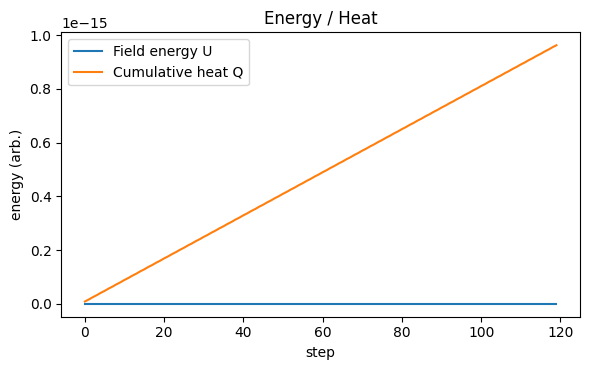

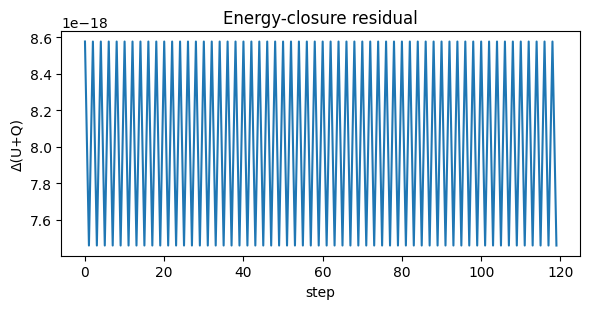

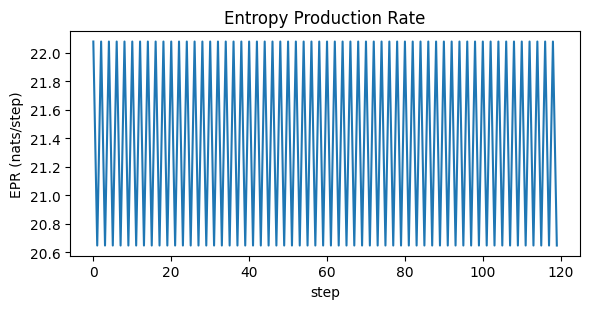

counts: {'samples': 120, 'energy': 120, 'heat': 120, 'residual': 120, 'phase_error': 0, 'E_mean': 0, 'B_mean': 0}
shapes: B1 (5, 15) B2 (15, 10) Star1 (15,) Star2 (10,)
USE_STAR: False |E|= 15 |F|= 10


In [ ]:
# @title 10. **Visualisations — Energy, Heat, Residuals, EPR, Phase** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Plots the main diagnostics:
# @markdown   • Cumulative heat `Q(t)` and field energy `U_field(t)`
# @markdown   • Energy-closure residual `Δ(U+Q)` (should hover near 0)
# @markdown   • EPR over sampled steps (if computable)
# @markdown   • Phase error (if provided in `hist`)
# @markdown - Prints a simple PASS/FLAG summary based on tolerances.

import numpy as np
import matplotlib.pyplot as plt

def plot_diagnostics(hist, diag, tol_resid=1e-6):
    # Pull streams
    s   = np.asarray(hist.get("samples", []), dtype=int)
    Q   = np.asarray(hist.get("heat", []), dtype=float)
    U   = np.asarray(hist.get("energy", []), dtype=float)
    R   = np.asarray(hist.get("residual", []), dtype=float)

    # 1) Energy & heat
    plt.figure(figsize=(6.0,3.8))
    if U.size: plt.plot(s, U, label="Field energy U")
    if Q.size: plt.plot(s, Q, label="Cumulative heat Q")
    plt.xlabel("step"); plt.ylabel("energy (arb.)"); plt.title("Energy / Heat"); plt.legend(); plt.tight_layout(); plt.show()

    # 2) Residual
    if R.size:
        plt.figure(figsize=(6.0,3.2))
        plt.plot(s, R)
        plt.xlabel("step"); plt.ylabel("Δ(U+Q)"); plt.title("Energy-closure residual"); plt.tight_layout(); plt.show()

    # 3) EPR
    epr_s = diag.get("EPR_series", {})
    epr_vals = np.asarray(epr_s.get("epr", []), dtype=float)
    epr_samps = np.asarray(epr_s.get("samples", []), dtype=int)
    if epr_vals.size:
        plt.figure(figsize=(6.0,3.2))
        plt.plot(epr_samps, epr_vals)
        plt.xlabel("step"); plt.ylabel("EPR (nats/step)"); plt.title("Entropy Production Rate"); plt.tight_layout(); plt.show()

    # 4) Phase error (optional)
    if "phase_error" in hist:
        pe = np.asarray(hist["phase_error"], dtype=float)
        ps = np.arange(len(pe))
        plt.figure(figsize=(6.0,3.2))
        plt.plot(ps, pe)
        plt.xlabel("index"); plt.ylabel("phase error (deg)"); plt.title("Phase error"); plt.tight_layout(); plt.show()


    # PASS/FLAG summary
    resid_max = float(np.nanmax(np.abs(R))) if R.size else np.nan
    epr_nonneg =_

# 0) Safety: inline plots (harmless if already set)
%matplotlib inline

# 1) Rebuild G (Geometry), Breath, DEC, Coupling — then:
hist = run_lenr_core(G, steps=120, dt=None, coherence_gain=0.1, report_every=1)
print("counts:", {k: len(hist.get(k, [])) for k in ["samples","energy","heat","residual"]})

# 2) Build diagnostics + plot (robust plotter handles missing x)
diag = diagnostics(G, hist)
plot_diagnostics(hist, diag)

print("counts:", {k: len(hist.get(k, [])) for k in ["samples","energy","heat","residual","phase_error","E_mean","B_mean"]})
print("shapes:", "B1", B1.shape, "B2", B2.shape, "Star1", np.diag(Star1).shape, "Star2", np.diag(Star2).shape)
print("USE_STAR:", USE_STAR, "|E|=", len(edge_id), "|F|=", len(face_id))

